# Lab 5: RRT Hardware Implementation

In this lab, you will work in teams to use your Rapidly-Exploring Random Tree (RRT) implementation from Lab 4 in practice. We have set up obstacles in the drone cage in G105. You will measure the positions of the obstacles, field, and starting/end locations, and use the RRT code to find a  trajectory through the space. We provide you the code to run the drone through a sequence of setpoints (in x,y) provided to it. You will be graded on your ability to autonomously navigate the drone from the starting position to the end goal location. 

As in the previous lab, you will work as a team. One team member will submit your results to the Dropbox. 

## Part 1: Recycling the RRT code from Lab 4. (10 Pts)

This lab is a little more open-ended than previous labs, with the objective of encouraging you to put together concepts you learned in class. 

**Please use the cells below to fill with your RRT code.** Since you are working as a group, take the opportunity to compare your different solutions to the previous homework. Some implementations were cleaner or more efficient than others, so use the version you like the best! 

You will use the RRT code to find the trajectory from the starting position to the end goal in the drone cage. We recommend keeping the format of the code consistent with your homework for debugging ease. 

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from numpy import linalg as LA

%matplotlib notebook

## TODO: Fill in the RRT code here, with corresponding helper functions.
k = 0.0254 #inches to meters

In [8]:
def conf_free(q: np.ndarray, obstacles: List[Tuple[np.ndarray, float]]) -> bool:
    """
    Check if a configuration is in the free space.
    
    This function checks if the configuration q lies outside of all the obstacles in the connfiguration space.
    
    @param q: An np.ndarray of shape (2,) representing a robot configuration.
    @param obstacles: A list of obstacles. Each obstacle is a tuple of the form (center, radius) representing a circle.
    @return: True if the configuration is in the free space, i.e. it lies outside of all the circles in `obstacles`. 
             Otherwise return False.
    """
 

    
    for obstacle in obstacles:
        
        # Difference vector
        diff = q - obstacle[0]
        radius = obstacle[1]
        
        # Distance between the configuration and center of the obstacle
        two_norm = LA.norm(diff)
        
        # As described in the Wikipedia article if the distance between the config and obstacle is less
        # than the radius it means its colliding, therefore not free (return False)
        if (two_norm**2 <= radius**2):
            return False
    
    return True    
        

def edge_free(edge: Tuple[np.ndarray, np.ndarray], obstacles: List[Tuple[np.ndarray, float]]) -> bool:
    """
    Check if a graph edge is in the free space.
    
    This function checks if a graph edge, i.e. a line segment specified as two end points, lies entirely outside of
    every obstacle in the configuration space.
    
    @param edge: A tuple containing the two segment endpoints.
    @param obstacles: A list of obstacles as described in `config_free`.
    @return: True if the edge is in the free space, i.e. it lies entirely outside of all the circles in `obstacles`. 
             Otherwise return False.
    """
    # For my analysis I am going to take the shortest distance between the edge (line) and the obstacle's center. 
    # Then I will check if it is less than the obstacle's radius, if yes, then the edge intersects the obstacle, thus not free
    # For the shortest distance I will use the formula given in https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line
    
    p1 = edge[0] # point 1 of the edge
    p2 = edge[1] # point 2 of the edge
    two_norm = LA.norm(p1 - p2)
    
    for obstacle in obstacles:
        # Formula used
        dist = abs((p2[1] - p1[1])*obstacle[0][0] - (p2[0] - p1[0])*obstacle[0][1] + p2[0]*p1[1] - p2[1]*p1[0])
        radius = obstacle[1]
        if ((dist/two_norm) <= radius):
            return False
        else:
            continue
    
    return True
        

In [28]:
def random_conf(width: float, height: float) -> np.ndarray:
    """
    Sample a random configuration from the configuration space.
    
    This function draws a uniformly random configuration from the configuration space rectangle. The configuration 
    does not necessarily have to reside in the free space.
    
    @param width: The configuration space width.
    @param height: The configuration space height.
    @return: A random configuration uniformily distributed across the configuration space.
    """
    x_coord = width * np.random.rand() - (30*k)
    y_coord = height * np.random.rand() 
    
    conf = np.array([x_coord, y_coord])
    
    return conf

def random_free_conf(width: float, height: float, obstacles: List[Tuple[np.ndarray, float]]) -> np.ndarray:
    """
    Sample a random configuration from the free space.
    
    This function draws a uniformly random configuration from the configuration space
    rectangle that lies in the free space.
    
    @param width: The configuration space width.
    @param height: The configuration space height.
    @param obstacles: The list of configuration space obstacles as defined in `edge_free` and `conf_free`.
    @return: A random configuration uniformily distributed across the configuration space.
    """
    
    # Iterate sampling new configurations until finding one that is free (not conflicting any obstacle)
    while (True): 
        conf = random_conf(width, height)
        if (conf_free(conf, obstacles)): 
            return conf
        


In [29]:
from numpy import linalg as LA

def nearest_vertex(conf: np.ndarray, vertices: np.ndarray) -> int:
    """
    Finds the nearest vertex to conf in the set of vertices.
    
    This function searches through the set of vertices and finds the one that is closest to 
    conf using the L2 norm (Euclidean distance).
    
    @param conf: The configuration we are trying to find the closest vertex to.
    @param vertices: The set of vertices represented as an np.array with shape (n, 2). Each row represents
                     a vertex.
    @return: The index (i.e. row of `vertices`) of the vertex that is closest to `conf`.
    """
    no_rows = vertices.shape[0]
    min_dist = 100000
    index = 0
    
    # Go through every element in the vertices array and check if they are the closes to the conf vertex
    for i in range(no_rows):
        euc_dist = LA.norm(conf - vertices[i])

        if (euc_dist < min_dist):
            min_dist = euc_dist
            index = i
            
    return index
    
    

def extend(origin: np.ndarray, target: np.ndarray, step_size: float=0.2) -> np.ndarray:
    """
    Extends the RRT at most a fixed distance toward the target configuration.
    
    Given a configuration in the RRT graph `origin`, this function returns a new configuration that takes a
    step of at most `step_size` towards the `target` configuration. That is, if the L2 distance between `origin`
    and `target` is less than `step_size`, return `target`. Otherwise, return the configuration on the line
    segment between `origin` and `target` that is `step_size` distance away from `origin`.
    
    @param origin: A vertex in the RRT graph to be extended.
    @param target: The vertex that is being extended towards.
    @param step_size: The maximum allowed distance the returned vertex can be from `origin`.
    
    @return: A new configuration that is as close to `target` as possible without being more than
            `step_size` away from `origin`.
    """

    # If L2 distance is less than step size return target
    if LA.norm(origin - target) < step_size:
        return target
    
    # Otherwise return the configuration on the line segment between origin and target of step size
    else:
        diff = target - origin
        two_norm = LA.norm(diff)
        unit_vector = diff / two_norm # Unit vector of the line segment between origin and target
        qs = unit_vector * step_size
        return (qs + origin)
        

In [80]:
def rrt(origin: np.ndarray, width: float, height: float, obstacles: List[Tuple[np.ndarray, float]],
        trials: int=1000, step_size: float=0.13) -> (np.ndarray, np.ndarray):
    """
    Explore a workspace using the RRT algorithm.
    
    This function builds an RRT using `trials` samples from the free space.
    
    @param origin: The starting configuration of the robot.
    @param width: The width of the configuration space.
    @param height: The height of the configuration space.
    @param obstacles: A list of circular obstacles.
    @param trials: The number of configurations to sample from the free space.
    @param step_size: The step_size to pass to `extend`.
    
    @return: A tuple (`vertices`, `parents`), where `vertices` is an (n, 2) `np.ndarray` where each row is a configuration vertex
             and `parents` is an array identifying the parent, i.e. `parents[i]` is the parent of the vertex in
             the `i`th row of `vertices.
    """
    num_verts = 1
    
    vertices = np.zeros((trials + 1, len(origin)))
    vertices[0, :] = origin
    
    parents = np.zeros(trials + 1, dtype=int)
    parents[0] = -1
    
    for trial in range(trials):
        
        # Randomly sample a configuration
        qrand = random_conf(width, height)
        
        # Find vertex that is closest to qrand
        near_row_index = nearest_vertex(qrand, vertices)
        qnear = vertices[near_row_index, :]
    
        # Extend qnear towards qrand
        qs = extend(qnear, qrand)
        
        edge = (qnear, qs)
        # Check if qs is in collision
        if conf_free(qs, obstacles) and edge_free(edge, obstacles): 
            # Add qs to V
            vertices[num_verts, :] = qs
            # Record the parent of the new configuration
            parents[num_verts] = near_row_index
            num_verts += 1
            
        else :
            continue
            
    
    return vertices[:num_verts, :], parents[:num_verts]

def backtrack(index: int, parents: np.ndarray) -> List[int]:
    """
    Find the sequence of nodes from the origin of the graph to an index.
    
    This function returns a List of vertex indices going from the origin vertex to the vertex `index`.
    
    @param index: The vertex to find the path through the tree to.
    @param parents: The array of vertex parents as specified in the `rrt` function.
    
    @return: The list of vertex indicies such that specifies a path through the graph to `index`.
    """
    
    path_list = []
    i = parents[index]
    # While we are not at the origin (where its -1) keep finding parents and added them to the path list
    while i != -1:
        path_list.append(i)
        i = parents[i]
    
    return path_list

## Part 2: Defining the Configuration Space. (40 Pts)

Now that you have your RRT code, you can start setting up the code to navigate the drone through the PVC pipe forest. 

The drone cage has been set up such that a series of PVC pipes are suspended from the ceiling. Your goal is to start your drone in the starting position, marked with an "X" on the ground in masking tape. You will be graded on your ability to land the drone within the end goal location, marked with a box and the word "END" in masking tape. And, of course, you will need to autonomously navigate from start to end while avoiding the obstacles in the drone's path. 

**Now: define your configuration space.** You will need to measure the obstacles and their positions, plus whatever other information about the drone cage you think is necessary (relative positions of start/end locations, the width and height of the field, etc.). Once these measurements are collected, you will simulate your trajectory through the cage below. Sample code from the previous homework has been provided to help you plot the trajectory. Think: How will you handle absolute positions vs. relative positions to the starting location? 

**It's also important to remember that for the Crazyflie, the positive X direction is forward (where the nub is) and the positive Y direction is to the left when you stand behind the drone**.

There is one additional caveat, however: **Remember to "inflate" your obstacles**, so that there is a buffer zone around each one. In practice, this will be necessary to help give the drone adequate space from each PVC pipe. We leave it up to you to assess how much to inflate the obstacles.

Once you have taken these measurements, fill out the code below:

In [190]:
## Sample code to define the space/obstacles and run the RRT:

## TODO: Take measurements in G105 and edit this block of code correspondingly. 
k = 0.0254 #inches to meters
# Width and height of the rectangular domain: 
width = 96.0*k  # total width of the cage
height = 150.0*k # total height of the cage

# Obstacles are represented as tuples, where the first element is an np.ndarray containing the center
# and the second element is the radius of the obstacle. For example (np.array([3, 4]), 5).
# This variable is a list of such tuples.
obstacles = []

# Measurements for the obstacles in meters
obstacles.append((np.array([-10*k,44*k]), (1+4)*k))
obstacles.append((np.array([33*k, 33*k]), (2.25+4)*k))
obstacles.append((np.array([4*k,70*k]), (.75+4)*k))
obstacles.append((np.array([23*k,68*k]), (1.75+4)*k))
obstacles.append((np.array([44*k,82*k]), (2.25+4)*k))


# The goal is represented in the same way as an obstacle.
# We tried using the actual x direction (120) for the drone, however, after 10+ trials it was 
# falling short each time. So we decided the scale it upwards to account for the uncertainities 
# in the sensor measurements.
goal = (np.array([45.7*k, 140*k]), (4)*k)

# The starting position of the robot.
origin = np.array([0, 0])

# Run the RRT to find the trajectory in this space: 
vertices, parents = rrt(origin, width, height, obstacles)

# Check if path was found: 
index = nearest_vertex(goal[0], vertices)
if np.linalg.norm(vertices[index, :] - goal[0]) < goal[1]:
    print('Path found!')
    path_verts = backtrack(index, parents)
else:
    print('No path found!')
    path_verts = []

Path found!


<IPython.core.display.Javascript object>


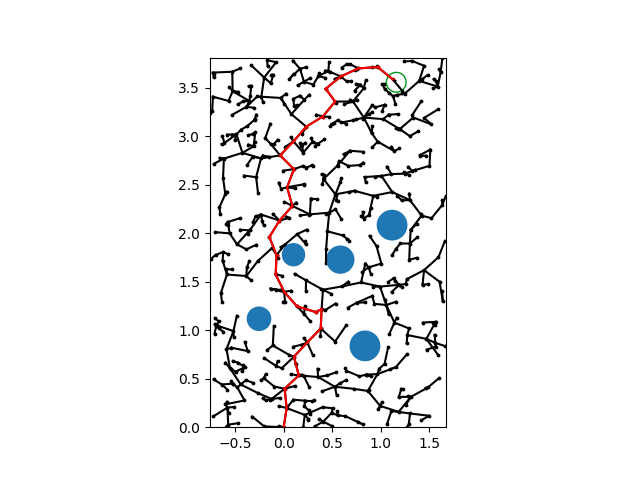

In [191]:
## Sample code to plot the trajectory: 
## Plot is flipped to match positive values of drone 
## origin is (0,0) to match drone
## scale in meters

fig, ax = plt.subplots()

ax.set_xlim([-30 *k, width -(k*30)])
ax.set_ylim([0, height])
ax.set_aspect('equal')

for i in range(len(parents)):
    if parents[i] < 0:
        continue
    plt.plot([vertices[i, 0], vertices[parents[i], 0]], 
             [vertices[i, 1], vertices[parents[i], 1]], c='k')

for i in path_verts:
    if parents[i] < 0:
        continue
    plt.plot([vertices[i, 0], vertices[parents[i], 0]], 
             [vertices[i, 1], vertices[parents[i], 1]], c='r')    

for o in obstacles:
    ax.add_artist(plt.Circle(tuple(o[0]), o[1]))
    
ax.add_artist(plt.Circle(tuple(goal[0]), goal[1], ec=(0.004, 0.596, 0.105), fc=(1, 1, 1)))

plt.scatter([2.5], [3.5], zorder=3, c=np.array([[0.004, 0.596, 0.105]]), s=3)
plt.scatter(vertices[path_verts, 0], vertices[path_verts, 1], c=np.array([[1, 0, 0]]), s=3, zorder=2)
plt.scatter(vertices[1:, 0], vertices[1:, 1], c=np.array([[0, 0, 0]]), s=3)

## Part 3: Hardware Implementation. (50 Pts)

Now that you have a trajectory, you can begin testing with the drone. 

First, define your group number (as in Lab 2):

In [40]:
group_number = 10

Here, we are providing code which takes your RRT trajectory (assuming the format of the output is consistent with that in Lab 4) and turns it into a sequence of setpoints which the drone can follow. 

In [41]:
def seg_to_setpoints(start_conf: np.ndarray, end_conf: np.ndarray) -> np.ndarray:
    # This function takes in the RRT trajectory and outputs a sequence of setpoints for the drone to follow. 
    
    dist = np.linalg.norm(start_conf - end_conf)
    num_samples = int(100 * dist)
    
    return end_conf.reshape((1, 2))

traj = origin.reshape(1, 2)
for i in range(len(path_verts) - 1):
    traj = np.concatenate((traj, seg_to_setpoints(vertices[path_verts[i]], vertices[path_verts[i + 1]])))

Here, we provide the code which actually tells the drone how to follow a sequence of setpoints:

In [64]:
# Code adapted from: https://github.com/bitcraze/crazyflie-lib-python/blob/master/examples/autonomousSequence.py

import time
# CrazyFlie imports: 
import cflib.crtp
from cflib.crazyflie import Crazyflie
from cflib.crazyflie.log import LogConfig
from cflib.crazyflie.syncCrazyflie import SyncCrazyflie
from cflib.crazyflie.syncLogger import SyncLogger

## Some helper functions: 
## -----------------------------------------------------------------------------------------

# Determine initial position: 
def wait_for_position_estimator(scf):
    print('Waiting for estimator to find position...')

    log_config = LogConfig(name='Kalman Variance', period_in_ms=500)
    log_config.add_variable('kalman.varPX', 'float')
    log_config.add_variable('kalman.varPY', 'float')
    log_config.add_variable('kalman.varPZ', 'float')

    var_y_history = [1000] * 10
    var_x_history = [1000] * 10
    var_z_history = [1000] * 10

    threshold = 0.001
    with SyncLogger(scf, log_config) as logger:
        for log_entry in logger:
            data = log_entry[1]

            var_x_history.append(data['kalman.varPX'])
            var_x_history.pop(0)
            var_y_history.append(data['kalman.varPY'])
            var_y_history.pop(0)
            var_z_history.append(data['kalman.varPZ'])
            var_z_history.pop(0)

            min_x = min(var_x_history)
            max_x = max(var_x_history)
            min_y = min(var_y_history)
            max_y = max(var_y_history)
            min_z = min(var_z_history)
            max_z = max(var_z_history)

            print("{} {} {}".
                format(max_x - min_x, max_y - min_y, max_z - min_z))

            if (max_x - min_x) < threshold and (
                    max_y - min_y) < threshold and (
                    max_z - min_z) < threshold:
                break

# Initialize controller: 
def set_PID_controller(cf):
    # Set the PID Controller:
    print('Initializing PID Controller')
    cf.param.set_value('stabilizer.controller', '1')
    cf.param.set_value('kalman.resetEstimation', '1')
    time.sleep(0.1)
    cf.param.set_value('kalman.resetEstimation', '0')
    
    wait_for_position_estimator(cf)
    time.sleep(0.1)    
    return

# Ascend and hover: 
def ascend_and_hover(cf):
    # Ascend:
    for y in range(20):
        cf.commander.send_hover_setpoint(0, 0, 0, y / 50)
        time.sleep(0.1)
    # Hover at 0.5 meters:
    for _ in range(30):
        cf.commander.send_hover_setpoint(0, 0, 0, 0.5)
        time.sleep(0.1)
    return

# Follow the setpoint sequence trajectory:
def run_sequence(scf, sequence, setpoint_delay):
    cf = scf.cf
    for position in sequence:
        print(f'Setting position {(position[0], (position[1]))}')
        for i in range(setpoint_delay):
            cf.commander.send_position_setpoint(position[0],
                                                (position[1]),
                                                0.5,
                                                0.0)
            time.sleep(0.1)
    
# Hover, descend, and stop all motion:
def hover_and_descend(cf):
    # Hover at 0.5 meters:
    for _ in range(30):
        cf.commander.send_hover_setpoint(0, 0, 0, 0.5)
        time.sleep(0.1)
    # Descend:
    for y in range(10):
        cf.commander.send_hover_setpoint(0, 0, 0, (10 - y) / 25)
        time.sleep(0.1)
    # Stop all motion:
    for i in range(10):
        cf.commander.send_stop_setpoint()
        time.sleep(0.1)
    return
## -----------------------------------------------------------------------------------------

def run_setpoint_trajectory(group_number, sequence):  
    # This is the main function to enable the drone to follow the trajectory. 
    
    # User inputs:
    #
    # - group_number: (int) the number corresponding to the drone radio settings. 
    #
    # - sequence: a series of point locations (float) defined as a numpy array, with each row in the following format: 
    #     [x(meters), y(meters)]
    #   Note: the input should be given in drone coordinates (where positive x is forward, and positive y is to the left).
    # Example: 
    # sequence = [
    #     [[ 0.          0.        ]
    #      [0.18134891  0.08433607]]
    # 

    # Outputs: 
    # None. 
    
    setpoint_delay = 3 # (int) Time to give the controller to reach next setpoint; in multiples of 0.1 s
    
    # Set the URI the Crazyflie will connect to
    uri = f'radio://0/{group_number}/2M'
    
    # Initialize all the CrazyFlie drivers:
    cflib.crtp.init_drivers(enable_debug_driver=False)

    # Sync to the CrazyFlie: 
    with SyncCrazyflie(uri, cf=Crazyflie(rw_cache='./cache')) as scf:
        # Get the Crazyflie class instance:
        cf = scf.cf

        # Initialize and ascend:
        set_PID_controller(cf)
        ascend_and_hover(cf)
        # Run the waypoint sequence:
        run_sequence(scf, sequence, setpoint_delay)
        # Descend and stop all motion: 
        hover_and_descend(cf)
            
    print('Done!') 
    return

**Putting it all together.**

**The objective: Get from the starting position to the end goal location without collisions.**

Use your RRT trajectory, the code provided to turn the trajectory into a sequence of setpoints, and the code provided to run the sequence of setpoints on the drone.

**The caveat**: You may need to modify some of your trajectory coordinates in order to get this to work. Think about how you defined your space initially, and then put this in terms of coordinates that the drone can understand. Again, from the perspective of the drone, positive x is **forward**, and positive y is to the **left**. The drone defines its origin at the starting point. 

The success of your run may depend strongly on how cleanly the drone ascends from its starting location. If your drone always ascends wildly, it will be difficult for the drone to hit the setpoints you defined. Make sure your hardware is in good conditions, as a single failing motor or damaged propeller may impact ascension consistently. 

In [192]:
# TODO: Implement any code necessary to convert your setpoint sequence to relative positions for the drone. 
traj = np.zeros((len(path_verts),2))
z = 0
# change x and y to match drone orientation 
for x in path_verts[::-1]:
    traj[z] = (np.array([vertices[x][1],vertices[x][0]]))
    z = z + 1

traj

array([[ 0.        ,  0.        ],
       [ 0.19757286,  0.03106391],
       [ 0.39647344,  0.01012218],
       [ 0.5336874 ,  0.15562933],
       [ 0.72758853,  0.10661554],
       [ 0.87370236,  0.24318328],
       [ 1.01753803,  0.38214839],
       [ 1.21733136,  0.39123827],
       [ 1.18714976,  0.33002278],
       [ 1.24499007,  0.13856913],
       [ 1.39486392,  0.00613866],
       [ 1.57426989, -0.08225532],
       [ 1.77407844, -0.07350647],
       [ 1.96001828, -0.14717043],
       [ 2.13061539, -0.04278353],
       [ 2.28058238,  0.08954146],
       [ 2.47323437,  0.0358273 ],
       [ 2.6605774 ,  0.10584579],
       [ 2.80171968, -0.03585409],
       [ 2.94704232,  0.10155526],
       [ 3.09808695,  0.23264881],
       [ 3.20232043,  0.40333971],
       [ 3.35663459,  0.5305684 ],
       [ 3.48884764,  0.43394058],
       [ 3.6156674 ,  0.58859098],
       [ 3.69888842,  0.77045429],
       [ 3.71180209,  0.97003695],
       [ 3.58540103,  1.12502976]])

In [193]:
# Run the setpoint sequence on the drone: 
run_setpoint_trajectory(group_number, traj)

Connecting to radio://0/10/2M
Connected to radio://0/10/2M
Initializing PID Controller
Waiting for estimator to find position...
999.999988878204 999.9999888668526 999.9997584844532
999.999988878204 999.9999888668526 999.9997584844532
999.999988878204 999.9999888668526 999.9997584844532
999.9999889414175 999.9999889301689 999.9997584844532
999.9999889414175 999.9999889301689 999.9997584844532
999.999989407349 999.9999893352951 999.9997584844532
999.999989407349 999.9999893352951 999.9997629073332
999.999989407349 999.9999893352951 999.9997629073332
999.999989407349 999.9999893352951 999.9997629073332
1.0734747775131837e-06 1.001653799903579e-06 3.201680374331772e-05
Setting position (0.0, 0.0)
Setting position (0.1975728556207448, 0.031063913498854873)
Setting position (0.3964734438568134, 0.010122184837020227)
Setting position (0.5336874037547631, 0.15562932971012897)
Setting position (0.727588533699236, 0.10661553770974808)
Setting position (0.8737023623529794, 0.24318328308230872)
S

# Submission Instructions

Submit this notebook along with a video of a successful flight as a .zip file [here](https://www.dropbox.com/request/zAdjD50fEgSItEZHXex5)